In [16]:
%matplotlib inline
import gym
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import deque
from IPython import display
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from scipy import stats
from training_methods import *
%load_ext autoreload
%autoreload

run_name = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# print(env.spec.max_episode_steps)

# env = gym.make('CartPole-v1')
# env.my_preprocess_input = lambda x: x

# env = gym.make('MountainCar-v0')
# env.my_preprocess_input = lambda x: x

# env = gym.make('Breakout-v0')
# env.my_preprocess_input = preprocess_input_breakout_v0

env = gym.make('Pong-v0')
env.my_preprocess_input = preprocess_input_pong_v0

# env.render(close=True)
# plt.imshow(env.render('rgb_array'))
print('Actions: {}, Observation space {}, {} parameters'.format(
    env.action_space.n, env.observation_space.shape, np.prod(env.observation_space.shape)))

[2017-08-19 11:40:29,709] Making new env: Pong-v0


Actions: 6, Observation space (210, 160, 3), 100800 parameters


## Basic Actor-Critic

In [3]:
class ActorCriticAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self._build_actor_model()
        self._build_critic_model()

    def _build_actor_model(self):
        with tf.variable_scope('actor'):
            self.actor_x = tf.placeholder("float", [None, self.params.state_size], name="State")
            self.actor_y = tf.placeholder("float", [None], name="Target")
            self.actor_action = tf.placeholder(tf.int32, [None], name="Action")

            h0 = tf.contrib.layers.fully_connected(
                inputs=self.actor_x,
                num_outputs=20,
                activation_fn=tf.nn.relu,
                weights_initializer=tf.contrib.layers.xavier_initializer())

            h1 = tf.contrib.layers.fully_connected(
                inputs=h0,
                num_outputs=self.params.action_size,
                activation_fn=None,
                weights_initializer=tf.contrib.layers.xavier_initializer())
            
            self.actor_action_probs = tf.nn.softmax(h1)

            with tf.variable_scope('apply_actions'):
                sh = tf.shape(self.actor_action_probs)
                action_flat = tf.reshape(self.actor_action_probs, [-1])
                picked_flat = tf.reshape(tf.range(0, sh[0]) * sh[1], [-1]) + self.actor_action
                self.picked_action_probs = tf.reshape(tf.gather(action_flat, picked_flat), [sh[0]])

            self.actor_loss = tf.reduce_mean(-tf.log(1e-6 + self.picked_action_probs) * self.actor_y)
            self.actor_train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99) \
                .minimize(self.actor_loss)

    def _build_critic_model(self):
        with tf.variable_scope('critic'):
            self.critic_x = tf.placeholder("float", [None, self.params.state_size], name="State")
            self.critic_y = tf.placeholder("float", [None], name="Target")

            h0 = tf.contrib.layers.fully_connected(
                inputs=self.critic_x,
                num_outputs=20,
                activation_fn=tf.nn.relu,
                weights_initializer=tf.contrib.layers.xavier_initializer())

            self.critic_value = tf.contrib.layers.fully_connected(
                inputs=h0,
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.contrib.layers.xavier_initializer())
            
            self.critic_loss = tf.reduce_mean(tf.squared_difference(self.critic_value, self.critic_y))
            self.critic_train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99) \
                .minimize(self.critic_loss)
            
    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        act_probs = session.run(self.actor_action_probs, {self.actor_x: [state]})[0]
        return np.random.choice(np.arange(len(act_probs)), p=act_probs)
#         return np.argmax(act_values)

    def think(self, batch_size, episode):
        cnt = len(self.memory)
        States = np.zeros((cnt, self.params.state_size))
        ActorY = np.zeros((cnt))
        Actions = np.zeros((cnt), dtype=np.int32)
        CriticY = np.zeros((cnt))
        
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            
            values = session.run(self.critic_value, {self.critic_x: [state, next_state]})
            
            td = reward + self.params.gamma * values[1][0]
            ad = td - values[0][0]
            
            States[i], ActorY[i], CriticY[i], Actions[i] = state, ad, td, action

        P = np.random.permutation(cnt)
        for i in range(0, cnt, batch_size):
            batch_indexes = P[i: i + batch_size]
            states = States[batch_indexes]
            actorys = ActorY[batch_indexes]
            criticys = CriticY[batch_indexes]
            actions = Actions[batch_indexes]
            _ = session.run(self.actor_train_op,
                            {self.actor_x: states, self.actor_y: actorys, self.actor_action: actions})
            _ = session.run(self.critic_train_op,
                            {self.critic_x: states, self.critic_y: criticys})

State shape (304,), actions 6
Run: 2
episode: 200/4000, reward -20.4, frames 1203, exploration rate: 0.86
episode: 400/4000, reward -20.5, frames 1171, exploration rate: 0.74
episode: 600/4000, reward -20.8, frames 1222, exploration rate: 0.64
episode: 800/4000, reward -20.2, frames 1247, exploration rate: 0.55
episode: 1000/4000, reward -20.6, frames 1294, exploration rate: 0.47
episode: 1200/4000, reward -20.3, frames 1347, exploration rate: 0.41
episode: 1400/4000, reward -19.8, frames 1344, exploration rate: 0.35
episode: 1600/4000, reward -20.7, frames 1083, exploration rate: 0.3
episode: 1800/4000, reward -20.0, frames 1271, exploration rate: 0.26
episode: 2000/4000, reward -20.2, frames 1201, exploration rate: 0.22
episode: 2200/4000, reward -20.2, frames 1421, exploration rate: 0.19
episode: 2400/4000, reward -20.9, frames 1072, exploration rate: 0.17
episode: 2600/4000, reward -20.3, frames 1484, exploration rate: 0.14
episode: 2800/4000, reward -18.7, frames 1139, exploration

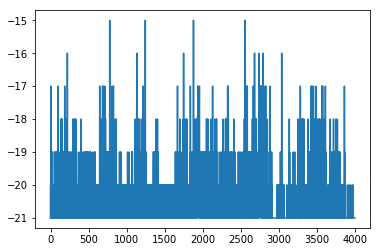

In [6]:
params = LearningParameters(env, episodes_count=4000)
params.max_frame_in_episode = min(params.max_frame_in_episode, 10000)
params.epsilon_min = 0.05

if 'session' in locals():
    session.close()
    tf.reset_default_graph()
    if 'tf_writer' in locals():
        tf_writer.close()
config = tf.ConfigProto(device_count = {'GPU': 0})
session = tf.Session(config=config)
run_name += 1
print('Run: ' + str(run_name))

agent = ActorCriticAgent(params)

tf_writer = tf.summary.FileWriter('logs/run' + str(run_name), session.graph)

session.run(tf.global_variables_initializer())

agent, rewards = train_discounted_rewards(env, agent, params, normalize_rewards=True)
# agent, rewards = train_reward_is_time(env, agent, params)
# agent, rewards = train(env, agent, params)
plt.plot(rewards)

episode: 250/5000, reward -20.2, frames 1010, exploration rate: 0.86
episode: 500/5000, reward -20.5, frames 1260, exploration rate: 0.74
episode: 750/5000, reward -20.7, frames 1324, exploration rate: 0.64
episode: 1000/5000, reward -20.6, frames 1050, exploration rate: 0.55
episode: 1250/5000, reward -20.7, frames 1152, exploration rate: 0.47
episode: 1500/5000, reward -20.8, frames 1258, exploration rate: 0.41
episode: 1750/5000, reward -21.0, frames 1167, exploration rate: 0.35
episode: 2000/5000, reward -21.0, frames 1131, exploration rate: 0.3
episode: 2250/5000, reward -20.3, frames 1248, exploration rate: 0.26
episode: 2500/5000, reward -20.7, frames 1130, exploration rate: 0.22
episode: 2750/5000, reward -20.7, frames 1260, exploration rate: 0.19
episode: 3000/5000, reward -20.5, frames 1548, exploration rate: 0.17
episode: 3250/5000, reward -20.9, frames 1188, exploration rate: 0.14
episode: 3500/5000, reward -21.0, frames 1134, exploration rate: 0.12
episode: 3750/5000, rewa

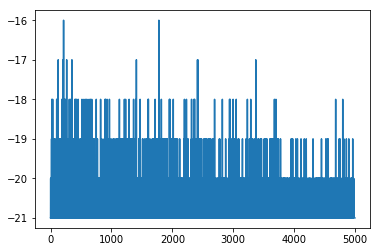

In [7]:
# Continue learning
params.episodes_count = 5000
agent, rewards = train_discounted_rewards(env, agent, params, normalize_rewards=True)
plt.plot(rewards)

In [14]:
evaluate(env, agent, params, 500)

Total reward: -9.0


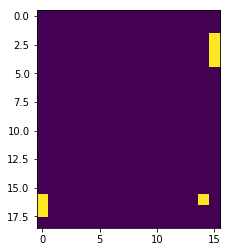

In [17]:
show(env, agent, params, 500, width=19, height=16, greedy=True)

In [18]:
# Save rewards/model
# pd.DataFrame(rewards).to_csv('models/rewards_40K_50K.csv', header=None)
saver = tf.train.Saver()
saver.save(session, 'models/Pong ActorCriticAgent', global_step=9000)

'models/Pong ActorCriticAgent-9000'